In [104]:
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_moons

In [105]:
# --- Data Generation ---
np.random.seed(42)
n_samples = 2000
means = np.array([[-1, -1], [1, 1]])
covariances = [np.array([[1, 0.5], [0.5, 1]]), np.array([[1, -0.5], [-0.5, 1]])]
proportions = [0.5, 0.5]
n_clusters = len(means)

# Generate data
data = []
labels = []
for i, (mean, cov, prop) in enumerate(zip(means, covariances, proportions)):
    n = int(prop * n_samples)
    cluster_data = np.random.multivariate_normal(mean, cov, n)
    data.append(cluster_data)
    labels += [i] * n
data = np.vstack(data)
labels = np.array(labels)

In [106]:
# --- Plotting Utility ---
def plot_clusters(data, labels, centroids=None, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if labels.ndim > 1:
        # c = labels[:, 0]
        c = np.argmax(labels, axis=1)
    else:
        c = labels
    ax.scatter(data[:, 0], data[:, 1], c=c, cmap="coolwarm", s=10)
    if centroids is not None:
        ax.scatter(centroids[:, 0], centroids[:, 1], s=300, c="black", marker="X")
    if title is not None:
        ax.set_title(title)

def plot_gaussian_ellipses(means, covariances, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for mean, cov in zip(means, covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            edgecolor="black",
            fc="None",
            lw=2,
        )
        ax.add_patch(ellipse)

In [107]:
# --- KMeans Class ---
class KMeansCustom:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def initialize_centroids(self, data):
        n_samples = data.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = data[indices]

    def assign_clusters(self, data):
        """
        Assign each point to the nearest centroid.
        """
        # DONE:  # Fill in this method
        labels = np.zeros(data.shape[0], dtype=int)
        for idx, data_point in enumerate(data):
            closest_dist = 10**10
            for i, centroid in enumerate(self.centroids):
                dist = np.linalg.norm(data_point-centroid)
                if dist < closest_dist:
                    labels[idx] = i 
                    closest_dist = dist

        return labels

    def update_centroids(self, data, labels):
        """
        Update centroids as the mean of all points assigned to each cluster.
        """
        # DONE:  # Fill in this method
        new_centroids = np.zeros((self.n_clusters, data.shape[1]))
        for cluster in range(self.n_clusters):
            cluster_points = data[labels == cluster]
            
            if len(cluster_points) > 0:
                new_centroids[cluster] = cluster_points.mean(axis=0)

        return new_centroids

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_centroids(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            labels = self.assign_clusters(data)
            new_centroids = self.update_centroids(data, labels)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "centroids": self.centroids.copy(),
                    "labels": labels.copy(),
                }
            self.centroids = new_centroids

    def predict(self, data):
        return self.assign_clusters(data)

In [108]:
# --- EM Class ---
class EMGMM:
    def __init__(self, n_components):
        self.n_components = n_components

    def initialize_params(self, data):
        n_samples, n_features = data.shape
        self.means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, data):
        """
        Compute responsibilities (soft assignments) for each cluster.
        """
        # Done:  Fill in this method
        n_samples, n_components = data.shape[0], self.n_components
        responsibilities = np.zeros((n_samples, n_components))

        for k in range(n_components):
            responsibilities[:, k] = self.weights[k] * self.multivariate_gaussian(data, self.means[k], self.covariances[k])

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def m_step(self, data, responsibilities):
        """
        Update means, covariances, and weights based on responsibilities.
        """
        # Done:  Fill in this method
        n_samples, n_features = data.shape
        Nk = responsibilities.sum(axis=0)  # Effective number of points for each cluster

        # Update weights
        self.weights = Nk / n_samples

        # Update means
        self.means = np.dot(responsibilities.T, data) / Nk[:, None]

        # Update covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = data - self.means[k]
            self.covariances[k] = np.dot((responsibilities[:, k][:, None] * diff).T, diff) / Nk[k]

    def multivariate_gaussian(self, data, mean, cov):
        """
        Compute the multivariate Gaussian probability density.
        """
        # Done:  Fill in this method
        n_features = data.shape[1]
        cov_inv = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        norm_factor = 1 / ((2 * np.pi) ** (n_features / 2) * np.sqrt(det_cov))
        diff = data - mean
        exp_term = np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
        return norm_factor * exp_term

    def fit(self, data, iterations_to_store=[0, 1, 2, 5, 10, 20]):
        self.initialize_params(data)
        self.stored_params = {}
        for i in range(max(iterations_to_store) + 1):
            responsibilities = self.e_step(data)
            self.m_step(data, responsibilities)
            if i in iterations_to_store:
                self.stored_params[i] = {
                    "means": self.means.copy(),
                    "covariances": self.covariances.copy(),
                    "responsibilities": responsibilities.copy(),
                }

    def predict(self, data):
        responsibilities = self.e_step(data)
        return np.argmax(responsibilities, axis=1)

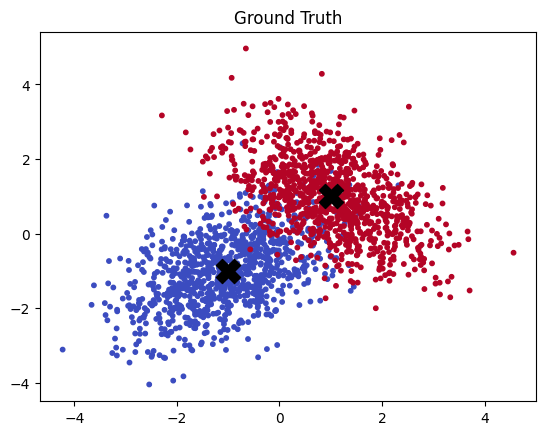

In [109]:
# --- Example Usage ---
# Plot initial data
plot_clusters(data, labels, means, title="Ground Truth")

In [110]:
# Run k-means
kmeans = KMeansCustom(n_clusters=n_clusters)
kmeans.fit(data)
kmeans_labels = kmeans.predict(data)

# Metrics
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
print(f"k-means ARI: {ari_kmeans:.3f}")

k-means ARI: 0.704


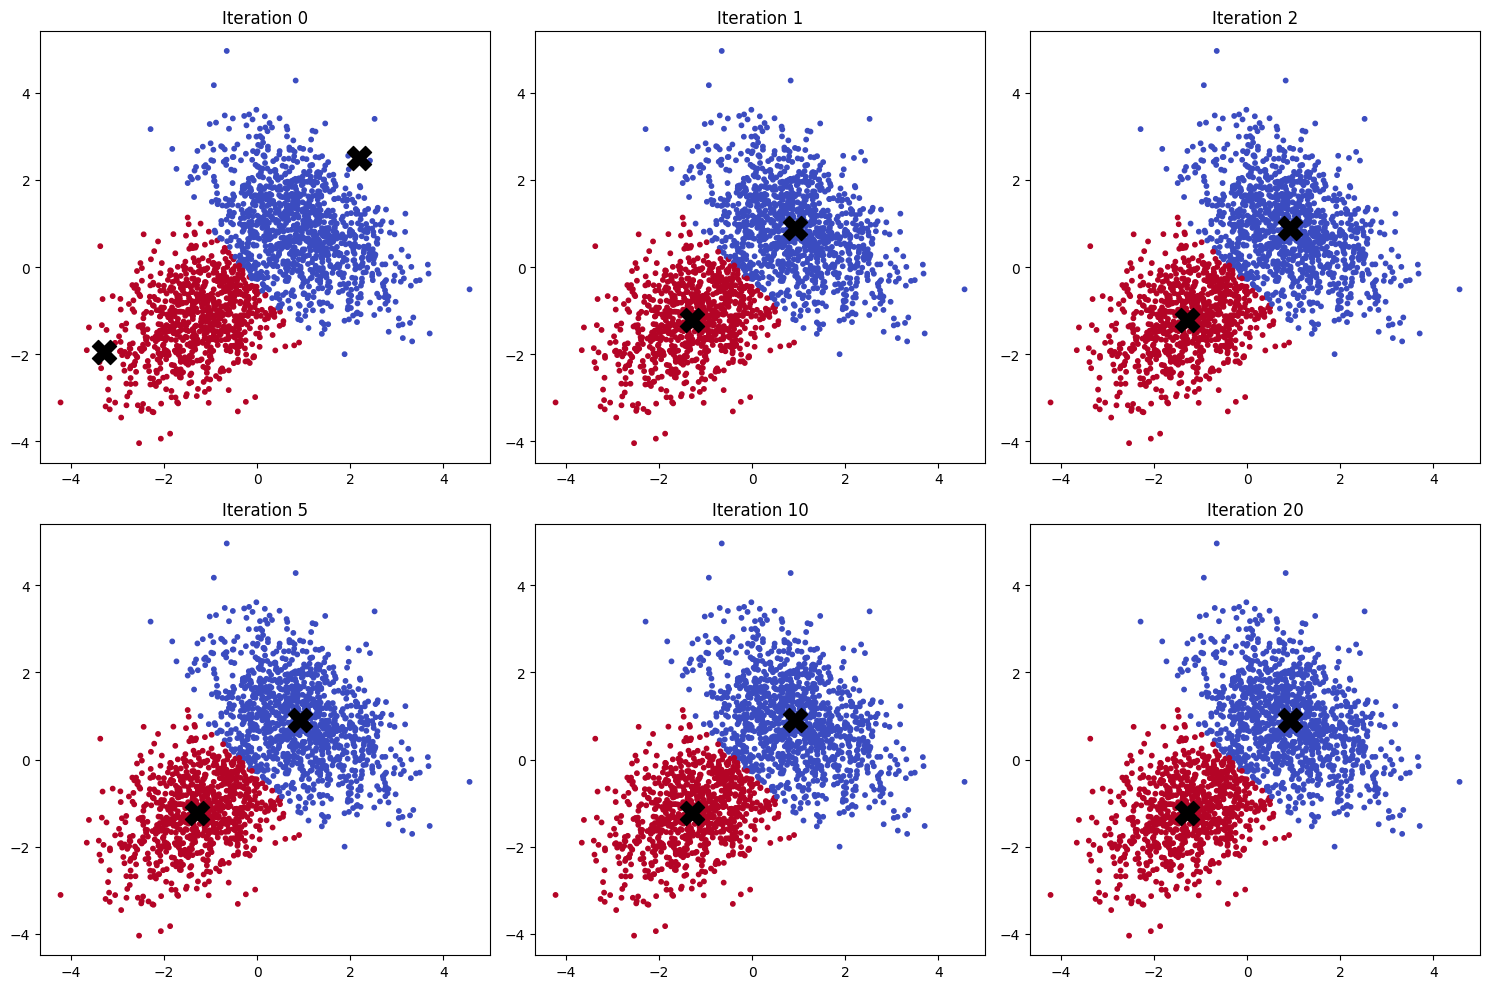

In [111]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = kmeans.stored_params[i]["labels"]
    em_centroids = kmeans.stored_params[i]["centroids"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    ax.set_title(f"Iteration {i}")
plt.tight_layout()

In [112]:
# Run EM
em = EMGMM(n_components=n_clusters)
em.fit(data)
em_labels = em.predict(data)

# Metrics
ari_em = adjusted_rand_score(labels, em_labels)
print(f"EM ARI: {ari_em:.3f}")

EM ARI: 0.771


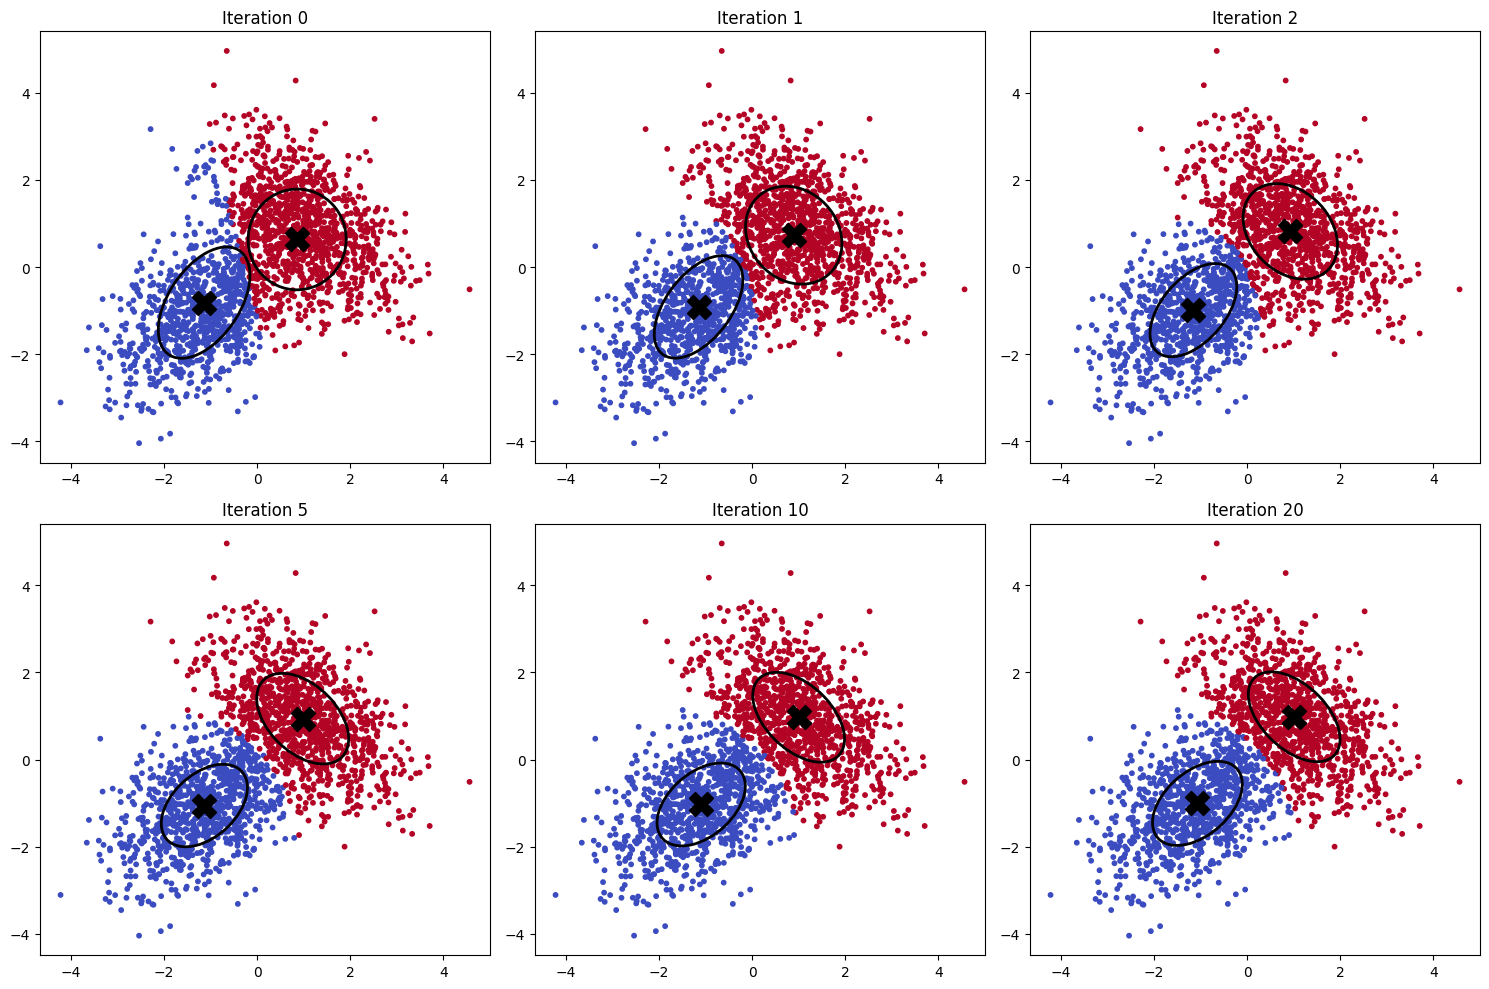

In [ ]:
iterations = [0, 1, 2, 5, 10, 20]
# Plot assignments at specified iterations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), iterations):
    responsibilities = em.stored_params[i]["responsibilities"]
    cov = em.stored_params[i]["covariances"]
    em_centroids = em.stored_params[i]["means"]
    plot_clusters(data, responsibilities, em_centroids, ax=ax)
    plot_gaussian_ellipses(em_centroids, cov, ax=ax)
    ax.set_title(f"Iteration {i}")
    
plt.tight_layout()

In [114]:
# ---- Q4 not done ----

k-means ARI (k=2): 0.704
1
EM ARI (k=2): 0.773
a 0.9999851451250821
k-means ARI (k=4): 0.383
2
EM ARI (k=4): 0.525
a 0.9304800701834505
k-means ARI (k=8): 0.229
5
EM ARI (k=8): 0.278
a 0.9670089236130845


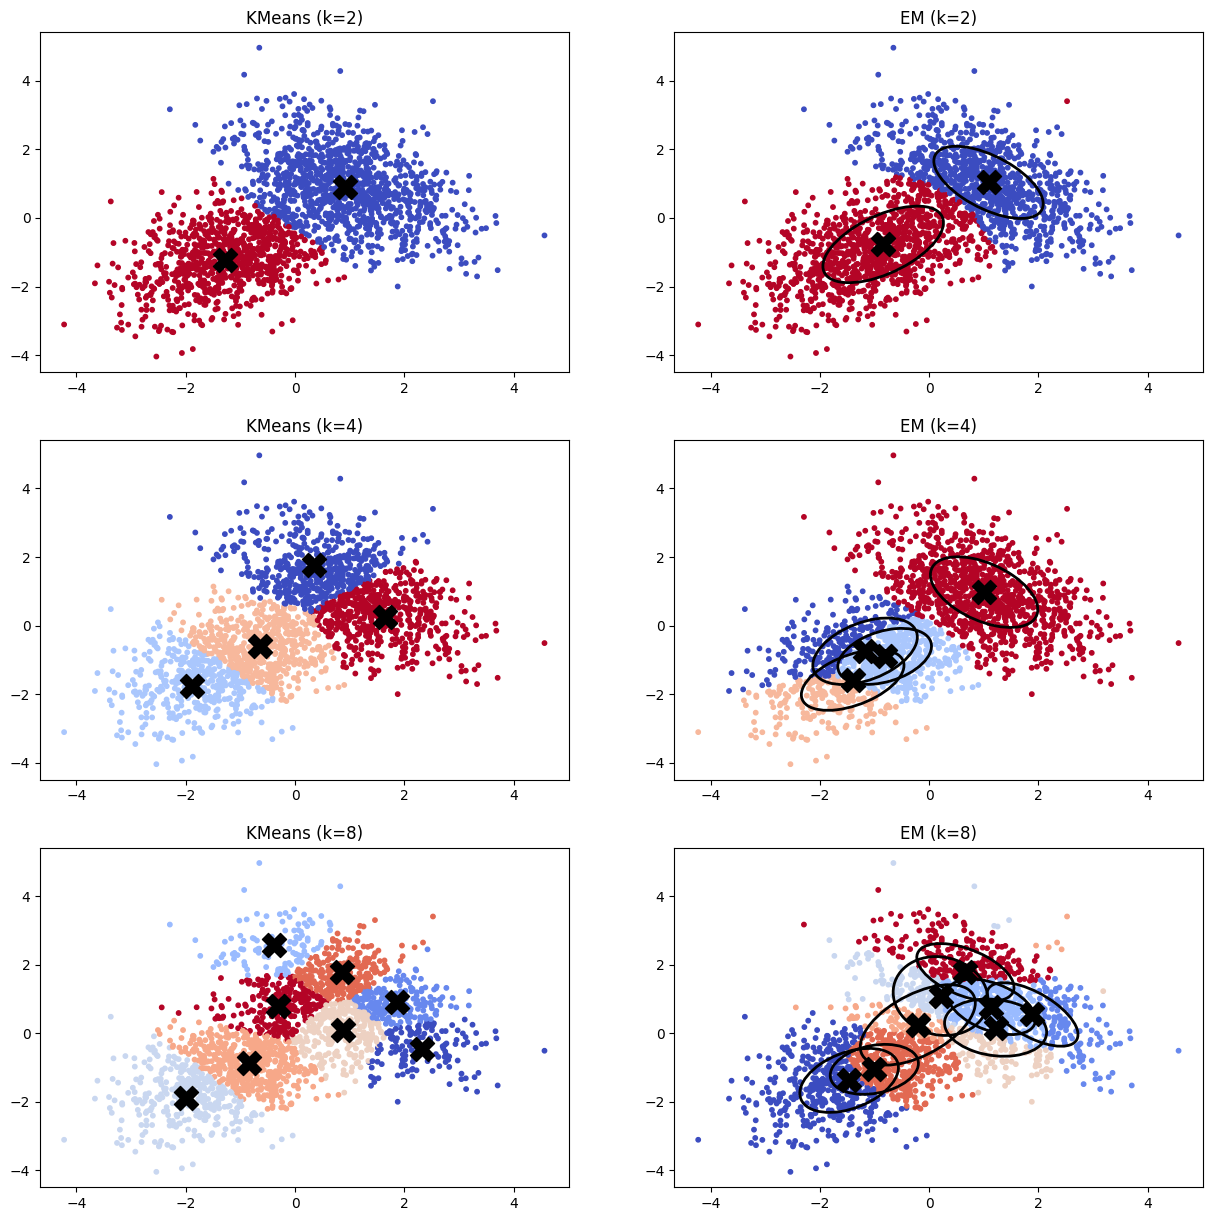

In [115]:
# --- Q5: The Effect of Overestimating Clusters ---

# TODO: # Fill in the code to run k-means and EM with different values of k and plot the results and ARI scores.
k_values = [2, 4, 8]
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
itertation = 10

for i, k in enumerate(k_values):
    # Run k-means
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(data)
    kmeans_labels = kmeans.predict(data)

    # Metrics
    ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
    print(f"k-means ARI (k={k}): {ari_kmeans:.3f}")

    # Plot assignments
    responsibilities = kmeans.stored_params[itertation]["labels"]
    print(max(responsibilities[:5]))
    em_centroids = kmeans.stored_params[itertation]["centroids"]
    plot_clusters(data, responsibilities, em_centroids, ax=axes[i, 0], title=f"KMeans (k={k})")

    # Run EM
    em = EMGMM(n_components=k)
    em.fit(data)
    em_labels = em.predict(data)

    # Metrics
    ari_em = adjusted_rand_score(labels, em_labels)
    print(f"EM ARI (k={k}): {ari_em:.3f}")

    # Plot assignments
    responsibilities = em.stored_params[itertation]["responsibilities"]
    print(f'a {max(responsibilities[:, 0])}')
    cov = em.stored_params[itertation]["covariances"]
    em_centroids = em.stored_params[itertation]["means"]
    plot_clusters(data, responsibilities, em_centroids, ax=axes[i, 1], title=f"EM (k={k})")
    plot_gaussian_ellipses(em_centroids, cov, ax=axes[i, 1])

k-means ARI (k=2): 0.243
EM ARI (k=2): 0.340
k-means ARI (k=4): 0.274
EM ARI (k=4): 0.487


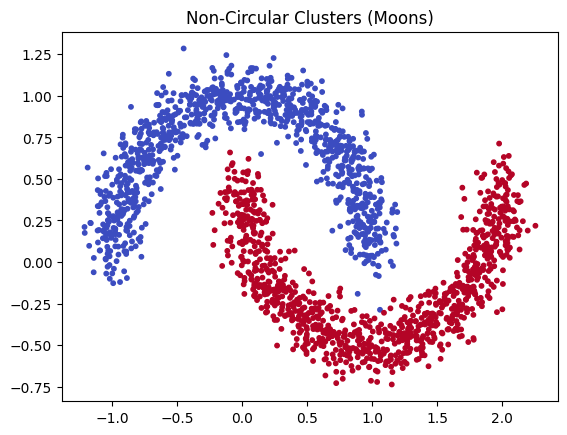

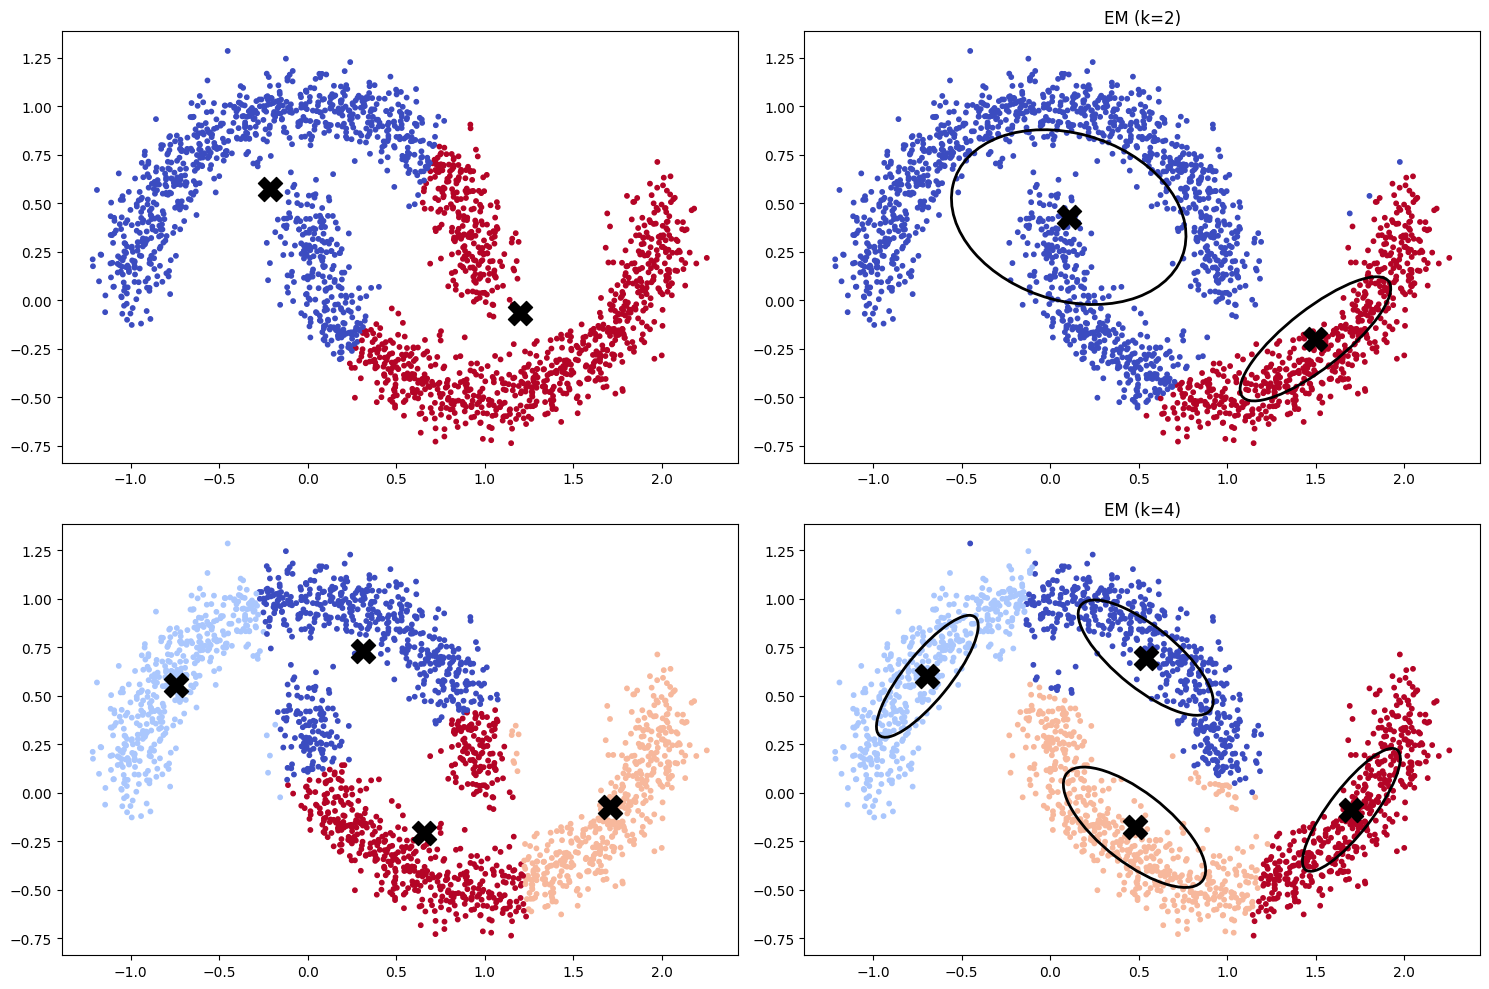

In [116]:
# --- Q6: Non-Circular Clusters (make_moons) ---
def generate_moons_data():
    data, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
    return data, labels

moons_data, moons_labels = generate_moons_data()
plot_clusters(moons_data, moons_labels, title="Non-Circular Clusters (Moons)")

# TODO: # Fill in the code to run k-means and EM on the moons dataset for k = 2 and 4 clusters and plot the results
k_values = [2, 4]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
itertation = 20

for i, k in enumerate(k_values):
    # Run k-means
    kmeans = KMeansCustom(n_clusters=k)
    kmeans.fit(moons_data)
    kmeans_labels = kmeans.predict(moons_data)

    # Metrics
    ari_kmeans = adjusted_rand_score(moons_labels, kmeans_labels)
    print(f"k-means ARI (k={k}): {ari_kmeans:.3f}")

    # Plot assignments
    responsibilities = kmeans.stored_params[itertation]["labels"]
    em_centroids = kmeans.stored_params[itertation]["centroids"]
    plot_clusters(moons_data, responsibilities, em_centroids, ax=axes[i, 0])

    # Run EM
    em = EMGMM(n_components=k)
    em.fit(moons_data)
    em_labels = em.predict(moons_data)

    # Metrics
    ari_em = adjusted_rand_score(moons_labels, em_labels)
    print(f"EM ARI (k={k}): {ari_em:.3f}")

    # Plot assignments
    responsibilities = em.stored_params[itertation]["responsibilities"]
    cov = em.stored_params[itertation]["covariances"]
    em_centroids = em.stored_params[itertation]["means"]
    plot_clusters(moons_data, responsibilities, em_centroids, ax=axes[i, 1], title=f"EM (k={k})")
    plot_gaussian_ellipses(em_centroids, cov, ax=axes[i, 1])

plt.tight_layout()


K-means asumes spherical clusters, while EM assumes gausian clusters.